In [1]:
# 계산
import numpy as np

# 전처리
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit

# 평가
from sklearn.metrics import mean_squared_error

# 모델링
import lightgbm as lgb

from sklearn.ensemble import GradientBoostingRegressor

# 출력 및 시각화
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# 데이터셋 로드 및 정제
import pandas as pd
import joblib
import os

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

/home/pervinco/miniconda3/envs/DL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
OHLCV_data = pd.read_parquet("/home/pervinco/Datasets/OHLCV.parquet")
company_data = pd.read_parquet("/home/pervinco/Datasets/Company.parquet")

OHLCV_data = OHLCV_data.sort_index()
OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

In [4]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"])
OHLCV_data.reset_index(drop=True, inplace=True)

# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")

OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)

# 파생 변수1 - 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]
# 파생 변수2 - 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] - OHLCV_data["Close"]) / 4
# 파생 변수3 - 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)
# 파생 변수4 - 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)
# 파생 변수5 - 장기, 중기, 단기 이동평균을 파생변수로 추가합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

# 파생 변수6 - 볼린저 밴드(Bolinger bands)는 이동 평균을 기준으로 상한, 하한 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2
std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())
# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

# 파생 변수7 - MACD (Moving Average Convergence & Divergence)는 추가 추세의 힘과 방향성을 파악하여 매매신호를 잡는 목적으로 사용됩니다.
OHLCV_data['ShortEMA'] = OHLCV_data["Close"].ewm(span=12, adjust=False).mean()
OHLCV_data['LongEMA'] = OHLCV_data["Close"].ewm(span=26, adjust=False).mean()
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

In [5]:
# 파생 변수8 - OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.
# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])
# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])
# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])
# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])
# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

# 파생 변수 9 - 시간관련 파생 변수
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.
# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day
# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

In [6]:
# Label Encoding을 진행합니다.
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
label_encoder = LabelEncoder()

OHLCV_data["LEncodedIndustry"] = label_encoder.fit_transform(OHLCV_data["industry"])
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])
OHLCV_data["LEncodedCode"] = label_encoder.fit_transform(OHLCV_data["code"])

# Frequency Encoding을 진행합니다.
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

# Target Encoding을 진행합니다.
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

In [7]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

OHLCV_data.drop([
    "company", "industry",
    "products", "listing_date", "closing_month",
    "region", "code"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

In [8]:
# 데이터의 날짜 범위를 알아보도록 하겠습니다.

display(f"데이터셋 날짜 범위: {OHLCV_data['Date'].min()} ~ {OHLCV_data['Date'].max()}")

'데이터셋 날짜 범위: 2020-06-25 00:00:00 ~ 2023-07-28 00:00:00'

In [9]:
# 마지막 1개월을 기준으로 학습/테스트 세트를 분리합니다.
train_data = OHLCV_data.loc[OHLCV_data["Date"] < "2023-07-01"].reset_index(drop=True)
test_data = OHLCV_data.loc[OHLCV_data["Date"] >= "2023-07-01"].reset_index(drop=True)

# 이후 time series split에서 사용하기 위해 날짜에 대한 정보를 별도로 저장해둡니다.
date_list = (train_data['Date'])

# Date 컬럼은 이제 필요가 없으니 제거하겠습니다.
train_data.drop("Date", axis=1, inplace=True)
test_data.drop("Date", axis=1, inplace=True)

display(f"학습 데이터셋 : {len(train_data)} 개")
display(f"테스트 데이터셋 : {len(test_data)} 개")

'학습 데이터셋 : 546452 개'

'테스트 데이터셋 : 15241 개'

In [10]:
# input값들과 target값을 구분합니다.
target_col = "Target" # 다음날의 종가 (Close)
input_cols = list(train_data.columns)
input_cols.remove(target_col)

display(f"Input Featrue : {input_cols}")
display(f"Target : {target_col}")

"Input Featrue : ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d', 'LowerBollingerBand', 'UpperBollingerBand', 'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay', 'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedProducts', 'LEncodedRegion', 'LEncodedCode', 'FEncodedIndustry', 'TEncodedIndustry']"

'Target : Target'

In [11]:
# 학습과 테스트세트에서 입력값과 목표값을 분리합니다.

X_train = train_data[input_cols]
Y_train = train_data[target_col]

X_test = test_data[input_cols]
Y_test = test_data[target_col]

display("학습에 사용할 최종 데이터의 형태는 아래와 같습니다.")
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Test Target : {Y_test.shape}")

'학습에 사용할 최종 데이터의 형태는 아래와 같습니다.'

'Train Input : (546452, 42)'

'Train Target : (546452,)'

'Test Input : (15241, 42)'

'Test Target : (15241,)'

#### 📝 설명 : (2-1)

- 가장 기본적인 분할 방법입니다.
- 전체 데이터를 8:2 등과 같이 일정 비율로 분리하는 기법으로, 랜덤하게 분리하거나 경우에 따라 가장 최근 20%를 검증데이터로 사용합니다.

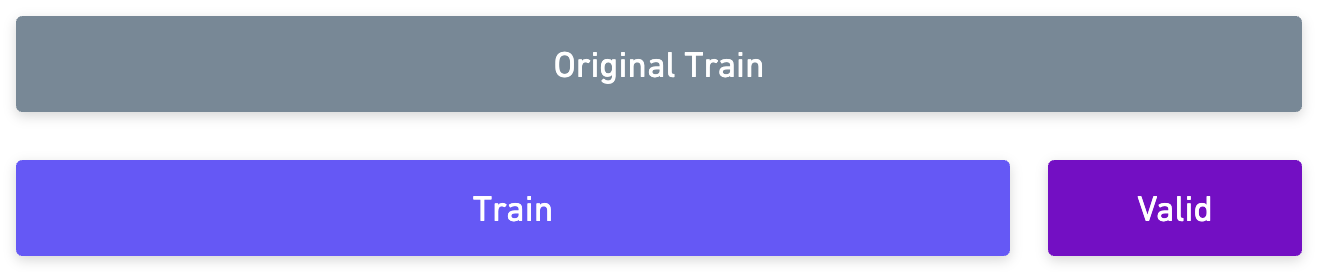

In [12]:
# 학습데이터를 학습/검증 데이터로 분리합니다.
# Sklearn의 Holdout을 이용해 랜덤으로 8:2로 분리합니다.

holdout_X_train, holdout_X_valid, holdout_Y_train, holdout_Y_valid = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True) # default shuffle : True

display(f"Train Input : {holdout_X_train.shape}")
display(f"Train Target : {holdout_Y_train.shape}")
display(f"Valid Input : {holdout_X_valid.shape}")
display(f"Valid Target : {holdout_Y_valid.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Valid Target : {Y_test.shape}")

'Train Input : (437161, 42)'

'Train Target : (437161,)'

'Valid Input : (109291, 42)'

'Valid Target : (109291,)'

'Test Input : (15241, 42)'

'Valid Target : (15241,)'

In [14]:
# LightGBM을 선언합니다.
# 학습은 총 1000번을 반복합니다.
# 데이터셋 분할에 따른 성능비교를 위해 별도의 Parameter 튜닝은 적용하지 않고 기본값을 사용합니다.

gbm = lgb.LGBMRegressor(n_estimators=1000)

# 학습을 진행합니다.
# 비교를 위해 %%time을 이용해 학습시간을 측정합니다.

gbm.fit(holdout_X_train, holdout_Y_train,                                                  # 학습 데이터를 입력합니다.
        eval_set=[(holdout_X_train, holdout_Y_train), (holdout_X_valid, holdout_Y_valid)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                 # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                          # 매 iteration마다 학습결과를 출력합니다.
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8140
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 41894.014720
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34915.1	training's l2: 1.21906e+09	valid_1's rmse: 34168.3	valid_1's l2: 1.16747e+09
[20]	training's rmse: 12856.2	training's l2: 1.65282e+08	valid_1's rmse: 12623.8	valid_1's l2: 1.59359e+08
[30]	training's rmse: 5809.53	training's l2: 3.37507e+07	valid_1's rmse: 5779.72	valid_1's l2: 3.34052e+07
[40]	training's rmse: 4025.26	training's l2: 1.62027e+07	valid_1's rmse: 4108.69	valid_1's l2: 1.68814e+07
[50]	training's rmse: 3620.55	training's l2: 1.31084e+07	valid_1's rmse: 3772.12	valid_1's l2: 1.42289e+07
[60]	training's rmse: 3452.64	training's l2: 1.19207e+07	

LGBMRegressor(n_estimators=1000)

In [ ]:
# 학습한 모델을 저장합니다.

# joblib.dump(gbm, 'holdout_gbm.pkl')

In [ ]:
# 저장한 모델을 불러옵니다.

# gbm_trained = joblib.load('holdout_gbm.pkl')

In [16]:
# 불러온 모델을 통해 추론을 진행합니다.
# 이후, Test set에 대한 rmse를 측정합니다.

predicts = gbm.predict(X_test)
RMSE = mean_squared_error(Y_test, predicts)**0.5
print(f"Test rmse : {RMSE}")

Test rmse : 3641.58252718185


#### 📝 설명 : (2-2)

- K번의 Holdout으로 데이터를 분리하는 방법입니다.
- K-1개를 학습 세트로, 1개를 검증 세트로 사용하며 동일한 Fold가 없도록 해야합니다.
- 최적의 학습,검증 Fold셋을 찾아내거나 모델들의 결과를 앙상블해서 사용합니다

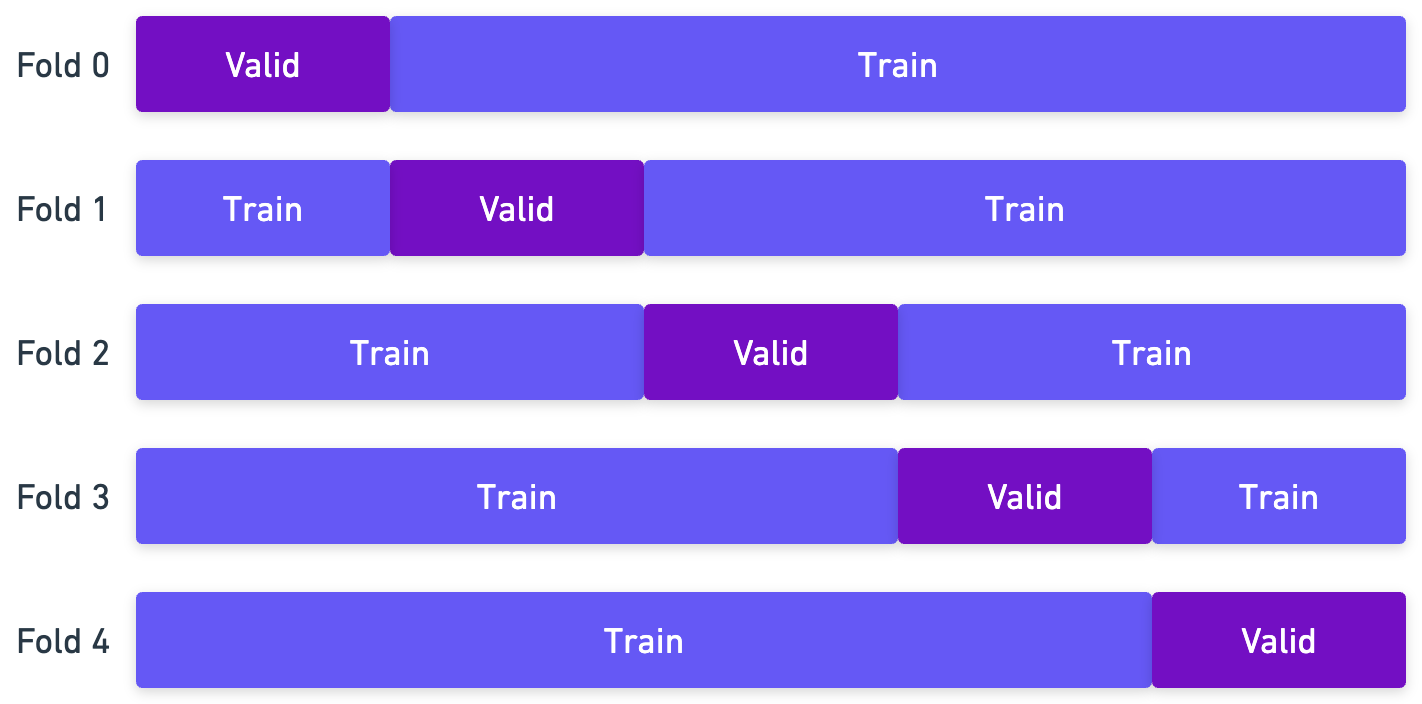


In [17]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

In [18]:
# Kfold 함수를 선언합니다.
kf = KFold(n_splits=5)

Fold 0 :
  Train : index=[109291 109292 109293 109294 109295]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[109291 109292 109293 109294 109295]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[218582 218583 218584 218585 218586]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[327872 327873 327874 327875 327876]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[437162 437163 437164 437165 437166]...


<Axes: title={'center': 'K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

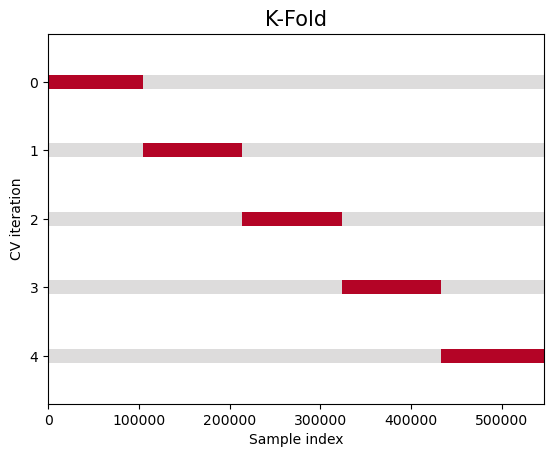

In [19]:
# kfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='K-Fold')

In [20]:
# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7f08a4430660>

In [21]:
# 학습을 진행합니다.
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8139
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 42761.930092
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34666.6	training's l2: 1.20177e+09	valid_1's rmse: 39919.4	valid_1's l2: 1.59356e+09
[20]	training's rmse: 12707.5	training's l2: 1.6148e+08	valid_1's rmse: 20928.9	valid_1's l2: 4.38018e+08
[30]	training's rmse: 5655.51	training's l2: 3.19848e+07	valid_1's rmse: 15407.7	valid_1's l2: 2.37396e+08
[40]	training's rmse: 3812.58	training's l2: 1.45358e+07	valid_1's rmse: 13700.4	valid_1's l2: 1.87701e+08
[50]	training's rmse: 3397.82	training's l2: 1.15452e+07	valid_1

In [22]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'kfold0_gbm.pkl - Test rmse : 3523.551637464711'

'kfold1_gbm.pkl - Test rmse : 3749.989271115124'

'kfold2_gbm.pkl - Test rmse : 3989.967552971793'

'kfold3_gbm.pkl - Test rmse : 3611.194050844959'

'kfold4_gbm.pkl - Test rmse : 3664.1980981647807'

'최종 Test rmse : 3290.6885777486605'

In [23]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.

top_3_files = ["kfold1_gbm.pkl", "kfold3_gbm.pkl", "kfold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'kfold1_gbm.pkl - Test rmse : 3749.989271115124'

'kfold3_gbm.pkl - Test rmse : 3611.194050844959'

'kfold4_gbm.pkl - Test rmse : 3664.1980981647807'

'최종 Test rmse : 3337.743295725452'

#### 📝 설명 : (2-3)

- K개의 Fold를 구성하는 방법은 K-Fold와 동일하지만, Fold별 Y의 비율도 동일하게 하는 분할 방법입니다.
- 데이터의 양이 적거나 불균형이 심한 데이터에 대해 K-Fold적용 시 분포가 크게 달라지는 현상을 방지할 수 있습니다.

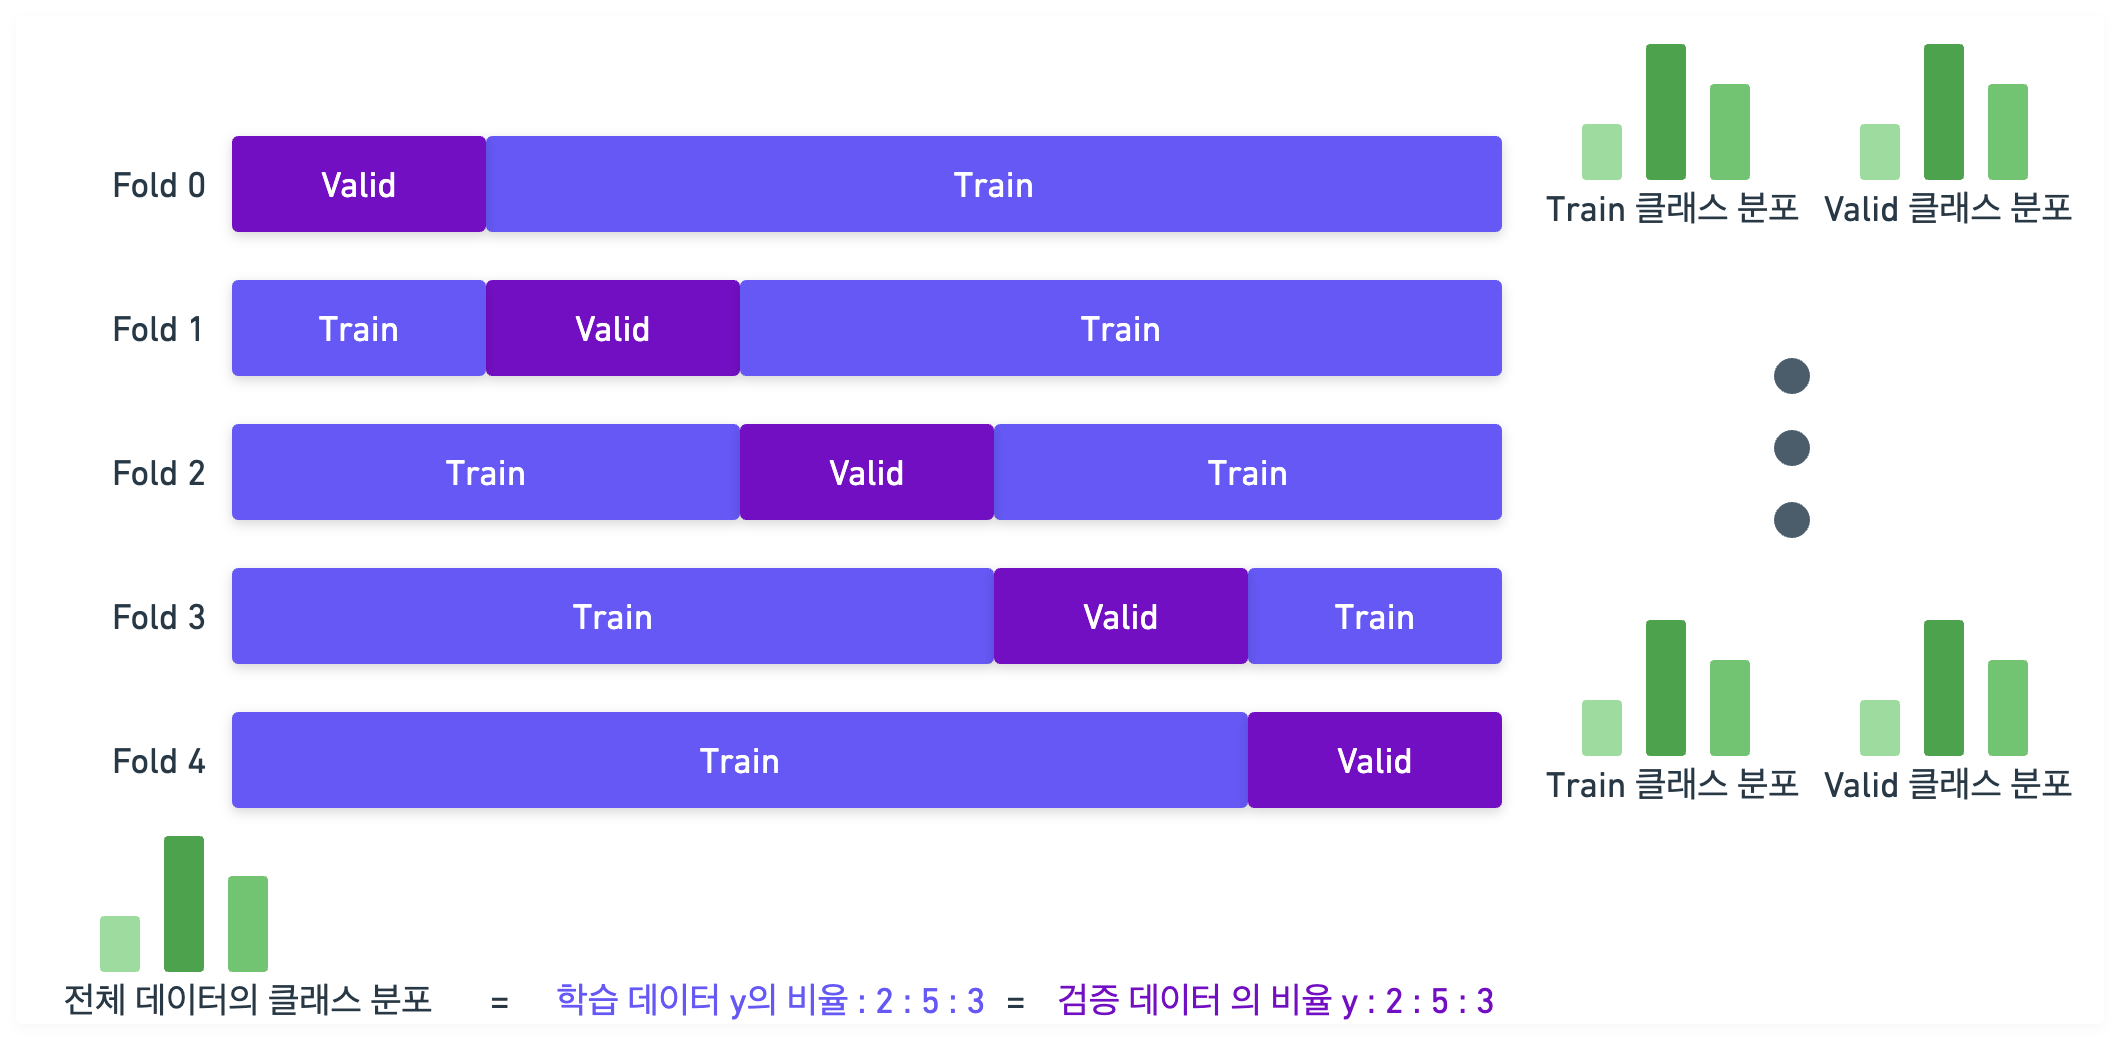

In [24]:
# Stratified Kfold 함수를 선언합니다.
kf = StratifiedKFold(n_splits=5)

# Target값을 기준으로 분포에 따라 1000등분합니다.
# Stratified KFold에서 각 구간을 기준으로 Y의 비율을 동일하게 가져가게 됩니다.
# 0, ... 9 = 0 / 10, ..., 19 = 1 / ..
cut_Y_train = pd.cut(Y_train,
                     1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                     labels=False)

Fold 0 :
  Train : index=[2227 3279 4044 4344 5733]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 3279  7388  7811  8034 13755]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 2227  4044  5733 16529 18755]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[17848 37847 42206 49326 49550]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 4344  5986  6623 14625 46910]...


<Axes: title={'center': 'Stratified K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

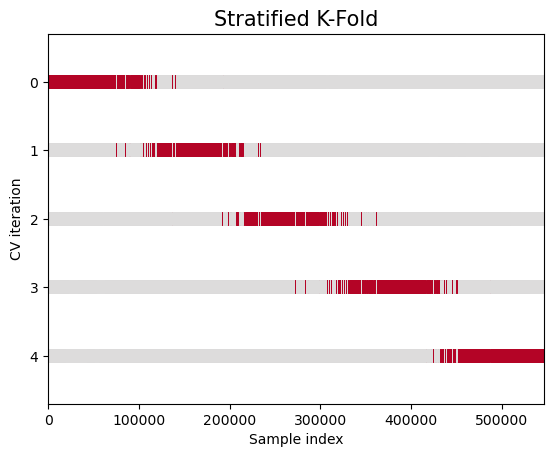

In [25]:
# Stratified Kfold를 시각화합니다.
# 앞의 kfold에서 정의한 시각화 함수를 사용합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=cut_Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Stratified K-Fold')

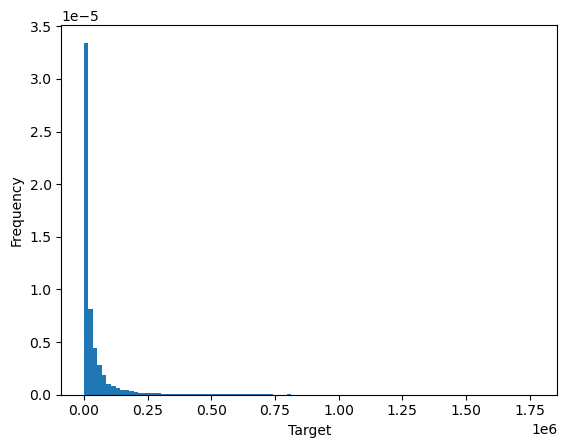

In [26]:
# 원래 Target값의 분포를 확인합니다.
plt.hist(Y_train, bins=100, density=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

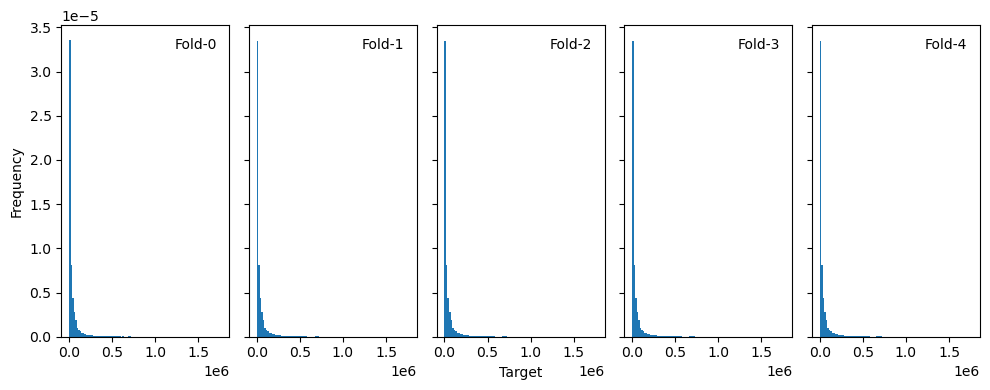

In [27]:
# 각 Fold별 분포를 시각화합니다.
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4)) # 5개의 plot을 만듭니다.
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, cut_Y_train)): # fold별로 iteration을 만듭니다.
    axs[fold_idx].hist(Y_train[train_idx], bins=100, density=True, label=f'Fold-{fold_idx}') # 각 fold에 해당하는 Target값을 가져옵니다.
    if fold_idx == 0:
        axs[fold_idx].set_ylabel('Frequency')
    if fold_idx == 2:
        axs[fold_idx].set_xlabel("Target")
    axs[fold_idx].legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

In [28]:
# 학습 데이터를 Stratified Kfold로 나눕니다.
train_folds = kf.split(X_train, cut_Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7f08a4491900>

In [30]:
# 학습을 진행합니다.
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold, # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse', # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10), # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)] # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"Stratified_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8140
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 41841.521488
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34771.6	training's l2: 1.20907e+09	valid_1's rmse: 35303.6	valid_1's l2: 1.24634e+09
[20]	training's rmse: 12800.8	training's l2: 1.63861e+08	valid_1's rmse: 13457.6	valid_1's l2: 1.81108e+08
[30]	training's rmse: 5779.16	training's l2: 3.33987e+07	valid_1's rmse: 6636.56	valid_1's l2: 4.40439e+07
[40]	training's rmse: 3976.89	training's l2: 1.58156e+07	valid_1's rmse: 4841.02	valid_1's l2: 2.34355e+07
[50]	training's rmse: 3538.83	training's l2: 1.25233e+07	valid_

'--------0번째 fold는 Stratified_kfold0_gbm.pkl에 저장되었습니다.--------\n\n'

--------1번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8141
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 41831.939350
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34746.8	training's l2: 1.20734e+09	valid_1's rmse: 34834.7	valid_1's l2: 1.21346e+09
[20]	training's rmse: 12821.8	training's l2: 1.644e+08	valid_1's rmse: 12763.3	valid_1's l2: 1.62903e+08
[30]	training's rmse: 5839.11	training's l2: 3.40953e+07	valid_1's rmse: 5886.5	valid_1's l2: 3.46509e+07
[40]	training's rmse: 4056.18	training's l2: 1.64526e+07	valid_1's rmse: 4338.07	valid_1's l2: 1.88188e+07
[50]	training's rmse: 3631.89	training's l2: 1.31906e+07	valid_1's

'--------1번째 fold는 Stratified_kfold1_gbm.pkl에 저장되었습니다.--------\n\n'

--------2번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8140
[LightGBM] [Info] Number of data points in the train set: 437162, number of used features: 42
[LightGBM] [Info] Start training from score 41843.743617
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34746.6	training's l2: 1.20733e+09	valid_1's rmse: 34654.8	valid_1's l2: 1.20096e+09
[20]	training's rmse: 12797.2	training's l2: 1.63768e+08	valid_1's rmse: 12705.7	valid_1's l2: 1.61434e+08
[30]	training's rmse: 5783.04	training's l2: 3.34436e+07	valid_1's rmse: 5826.61	valid_1's l2: 3.39494e+07
[40]	training's rmse: 3999.89	training's l2: 1.59991e+07	valid_1's rmse: 4294.32	valid_1's l2: 1.84412e+07
[50]	training's rmse: 3590.94	training's l2: 1.28949e+07	valid_

'--------2번째 fold는 Stratified_kfold2_gbm.pkl에 저장되었습니다.--------\n\n'

--------3번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8141
[LightGBM] [Info] Number of data points in the train set: 437162, number of used features: 42
[LightGBM] [Info] Start training from score 41844.352233
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34778.7	training's l2: 1.20956e+09	valid_1's rmse: 34524.9	valid_1's l2: 1.19197e+09
[20]	training's rmse: 12834.5	training's l2: 1.64723e+08	valid_1's rmse: 12661.1	valid_1's l2: 1.60302e+08
[30]	training's rmse: 5832.21	training's l2: 3.40147e+07	valid_1's rmse: 5750.71	valid_1's l2: 3.30706e+07
[40]	training's rmse: 4055.55	training's l2: 1.64475e+07	valid_1's rmse: 4115.33	valid_1's l2: 1.6936e+07
[50]	training's rmse: 3643.56	training's l2: 1.32756e+07	valid_1

'--------3번째 fold는 Stratified_kfold3_gbm.pkl에 저장되었습니다.--------\n\n'

--------4번째 fold의 학습을 시작합니다.--------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8139
[LightGBM] [Info] Number of data points in the train set: 437162, number of used features: 42
[LightGBM] [Info] Start training from score 41849.431618
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34815.2	training's l2: 1.2121e+09	valid_1's rmse: 34497.9	valid_1's l2: 1.19011e+09
[20]	training's rmse: 12838.2	training's l2: 1.6482e+08	valid_1's rmse: 12829.2	valid_1's l2: 1.64588e+08
[30]	training's rmse: 5843.73	training's l2: 3.41491e+07	valid_1's rmse: 6177.08	valid_1's l2: 3.81563e+07
[40]	training's rmse: 4061.79	training's l2: 1.64981e+07	valid_1's rmse: 4614.11	valid_1's l2: 2.129e+07
[50]	training's rmse: 3639.9	training's l2: 1.32489e+07	valid_1's r

'--------4번째 fold는 Stratified_kfold4_gbm.pkl에 저장되었습니다.--------\n\n'

In [31]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'Stratified_kfold0_gbm.pkl - Test rmse : 3473.663129019916'

'Stratified_kfold1_gbm.pkl - Test rmse : 3416.7095341601184'

'Stratified_kfold2_gbm.pkl - Test rmse : 3507.200676966335'

'Stratified_kfold3_gbm.pkl - Test rmse : 3631.0386472031064'

'Stratified_kfold4_gbm.pkl - Test rmse : 3533.774502184208'

'최종 Test rmse : 3304.084320050569'

In [32]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
# 실습하는 과정에서 가장 잘 나온 3개로 한번 테스트를 진행해보시기 바랍니다.
top_3_files = ["Stratified_kfold1_gbm.pkl", "Stratified_kfold2_gbm.pkl", "Stratified_kfold3_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'Stratified_kfold1_gbm.pkl - Test rmse : 3416.7095341601184'

'Stratified_kfold2_gbm.pkl - Test rmse : 3507.200676966335'

'Stratified_kfold3_gbm.pkl - Test rmse : 3631.0386472031064'

'최종 Test rmse : 3380.2759540643915'

#### 📝 설명 : (2-4)
- 특정 목적하에 사용되는 확장된 K-Fold 방법입니다.
- Train과 Valid에 같은 값이 들어가지 않도록 Group을 구성 후, Fold별로 Group을 분배합니다.
- 이번 실습에서는 group을 종목별과 산업군별로 각각 group kfold를 적용해봅니다.

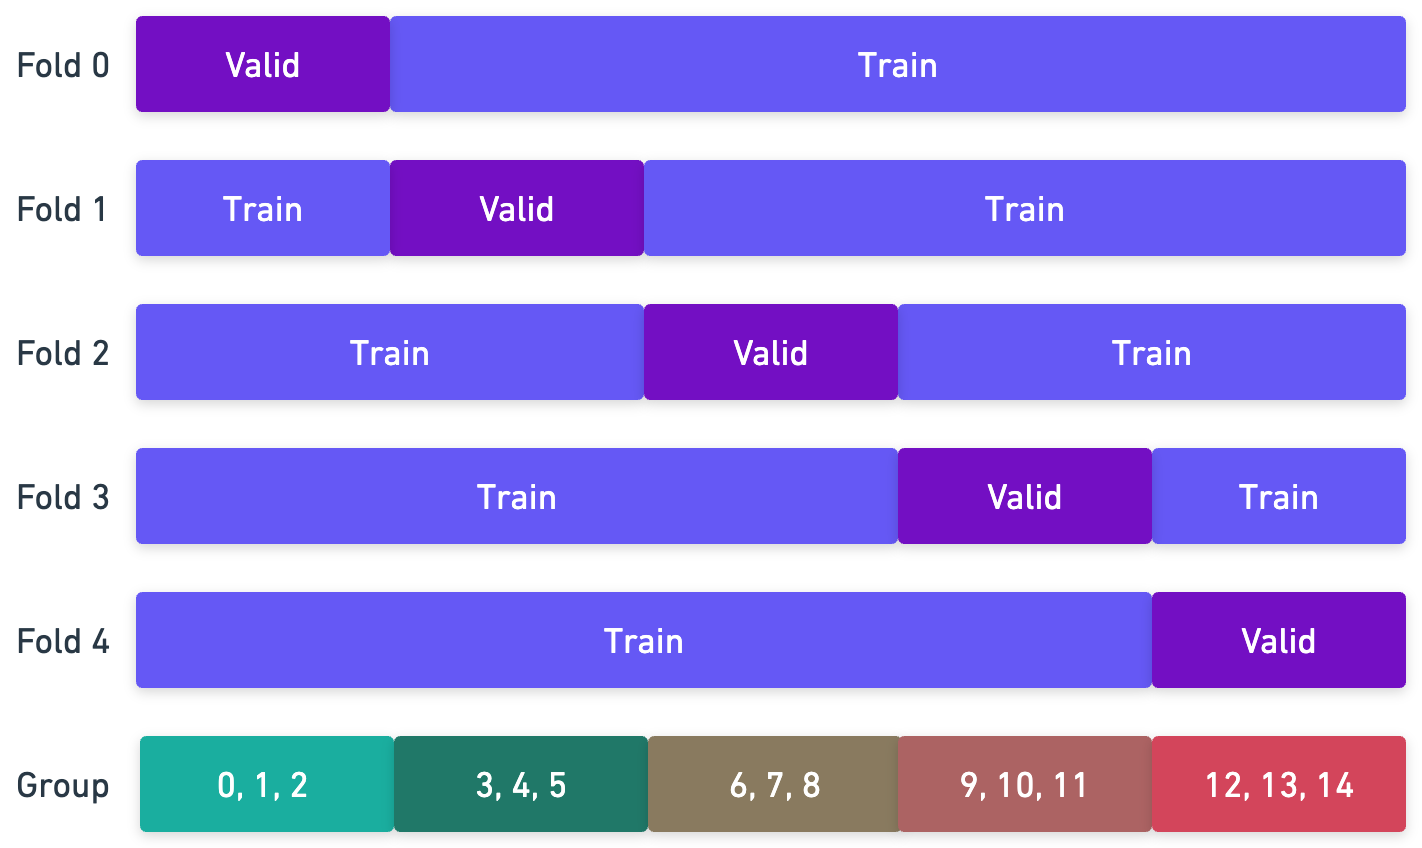

In [33]:
# 종목(code)를 Group을 나누는 기준으로 사용합니다.
groups = list(X_train['LEncodedCode'].astype('int'))

In [34]:
# GroupKfold 함수를 선언합니다.
kf = GroupKFold(n_splits=5)

Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 6  8 18 26 28]...
Fold 1 :
  Train : index=[1 3 5 6 7]...
  Valid : index=[ 0  2  4 25 29]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 7  9 12 13 20]...
Fold 3 :
  Train : index=[0 2 3 4 6]...
  Valid : index=[ 1  5 11 14 16]...
Fold 4 :
  Train : index=[0 1 2 4 5]...
  Valid : index=[ 3 10 15 17 23]...


<Axes: title={'center': 'Code Group K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

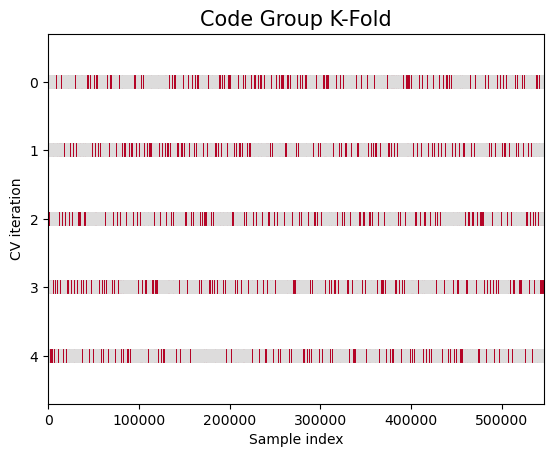

In [35]:
# GroupKfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train.sort_values(by='LEncodedCode'),
                y=Y_train,
                cv=kf,
                group=groups,
                ax=ax,
                split_strategy='Code Group K-Fold')

In [36]:
# 학습 데이터를 GroupKfold로 나눕니다.
train_folds = kf.split(X_train, Y_train, groups=groups)
display(train_folds)

<generator object _BaseKFold.split at 0x7f081406d820>

In [38]:
# 학습을 진행합니다.
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"groupd_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8120
[LightGBM] [Info] Number of data points in the train set: 437169, number of used features: 42
[LightGBM] [Info] Start training from score 40921.370770
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35791.8	training's l2: 1.28105e+09	valid_1's rmse: 30110.7	valid_1's l2: 9.06653e+08
[20]	training's rmse: 13120.2	training's l2: 1.72139e+08	valid_1's rmse: 11329.7	valid_1's l2: 1.28362e+08
[30]	training's rmse: 5806.61	training's l2: 3.37167e+07	valid_1's rmse: 5600.43	valid_1's l2: 3.13648e+07
[40]	training's rmse: 3908.11	training's l2: 1.52733e+07	valid_1's rmse: 4178.88	valid_1's l2: 1.7463e+07
[50]	training's rmse: 3469.09	training's l2: 1.20346e+07	valid_1's rmse: 3888.61	valid_1's l2: 1.5121

'--------0번째 fold는 groupd_kfold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 437163, number of used features: 42
[LightGBM] [Info] Start training from score 43975.810798
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 36476.6	training's l2: 1.33054e+09	valid_1's rmse: 26471.6	valid_1's l2: 7.00745e+08
[20]	training's rmse: 13408.4	training's l2: 1.79784e+08	valid_1's rmse: 10106	valid_1's l2: 1.02132e+08
[30]	training's rmse: 6017.99	training's l2: 3.62161e+07	valid_1's rmse: 5786.07	valid_1's l2: 3.34786e+07
[40]	training's rmse: 4100.52	training's l2: 1.68142e+07	valid_1's rmse: 5118.39	valid_1's l2: 2.61979e+07
[50]	training's rmse: 3670	training's l2: 1.34689e+07	valid_1's rmse: 5027.44	valid_1's l2: 2.52751e+0

'--------1번째 fold는 groupd_kfold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8126
[LightGBM] [Info] Number of data points in the train set: 437176, number of used features: 42
[LightGBM] [Info] Start training from score 38637.911530
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 28524.4	training's l2: 8.13643e+08	valid_1's rmse: 75077.5	valid_1's l2: 5.63662e+09
[20]	training's rmse: 10546.2	training's l2: 1.11222e+08	valid_1's rmse: 52804.2	valid_1's l2: 2.78829e+09
[30]	training's rmse: 4883.71	training's l2: 2.38506e+07	valid_1's rmse: 46582.6	valid_1's l2: 2.16994e+09
[40]	training's rmse: 3457.48	training's l2: 1.19542e+07	valid_1's rmse: 44934.2	valid_1's l2: 2.01908e+09
[50]	training's rmse: 3129.13	training's l2: 9.79144e+06	valid_1's rmse: 44416.8	valid_1's l2: 1.972

'--------2번째 fold는 groupd_kfold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8116
[LightGBM] [Info] Number of data points in the train set: 437142, number of used features: 42
[LightGBM] [Info] Start training from score 42706.281014
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 36226.2	training's l2: 1.31234e+09	valid_1's rmse: 27539.7	valid_1's l2: 7.58433e+08
[20]	training's rmse: 13309.5	training's l2: 1.77143e+08	valid_1's rmse: 9988.36	valid_1's l2: 9.97673e+07
[30]	training's rmse: 5957.59	training's l2: 3.54928e+07	valid_1's rmse: 4972.76	valid_1's l2: 2.47283e+07
[40]	training's rmse: 4079.99	training's l2: 1.66463e+07	valid_1's rmse: 4114.84	valid_1's l2: 1.69319e+07
[50]	training's rmse: 3658.63	training's l2: 1.33856e+07	valid_1's rmse: 4002.63	valid_1's l2: 1.602

'--------3번째 fold는 groupd_kfold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8120
[LightGBM] [Info] Number of data points in the train set: 437158, number of used features: 42
[LightGBM] [Info] Start training from score 42969.776548
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35951.2	training's l2: 1.29249e+09	valid_1's rmse: 29415.4	valid_1's l2: 8.65266e+08
[20]	training's rmse: 13174.9	training's l2: 1.73579e+08	valid_1's rmse: 10983.6	valid_1's l2: 1.20639e+08
[30]	training's rmse: 5846.55	training's l2: 3.41821e+07	valid_1's rmse: 5416.9	valid_1's l2: 2.93428e+07
[40]	training's rmse: 3955.69	training's l2: 1.56475e+07	valid_1's rmse: 4597.43	valid_1's l2: 2.11364e+07
[50]	training's rmse: 3506.57	training's l2: 1.2296e+07	valid_1's rmse: 4638.24	valid_1's l2: 2.15133

'--------4번째 fold는 groupd_kfold4_gbm.pkl에 저장되었습니다.--------\n\n'

In [39]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'groupd_kfold0_gbm.pkl - Test rmse : 3659.8952677815055'

'groupd_kfold1_gbm.pkl - Test rmse : 3531.21613524062'

'groupd_kfold2_gbm.pkl - Test rmse : 4048.7659010704933'

'groupd_kfold3_gbm.pkl - Test rmse : 3943.034626449951'

'groupd_kfold4_gbm.pkl - Test rmse : 3797.081519919555'

'최종 Test rmse : 3462.962159042014'

In [40]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["groupd_kfold0_gbm.pkl", "groupd_kfold2_gbm.pkl", "groupd_kfold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'groupd_kfold0_gbm.pkl - Test rmse : 3659.8952677815055'

'groupd_kfold2_gbm.pkl - Test rmse : 4048.7659010704933'

'groupd_kfold4_gbm.pkl - Test rmse : 3797.081519919555'

'최종 Test rmse : 3518.7539711839086'

In [ ]:
# 산업군(Industry)를 Group을 나누는 기준으로 사용합니다.
groups = list(X_train['LEncodedIndustry'].astype('int'))

In [ ]:
# GroupKfold 함수를 선언합니다.
kf = GroupKFold(n_splits=5)

Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[5464 5465 5466 5467 5468]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[11426 11427 11428 11429 11430]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[162874 162875 162876 162877 162878]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[14700 14701 14702 14703 14704]...
Fold 4 :
  Train : index=[5464 5465 5466 5467 5468]...
  Valid : index=[0 1 2 3 4]...


<Axes: title={'center': 'Industry Group K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

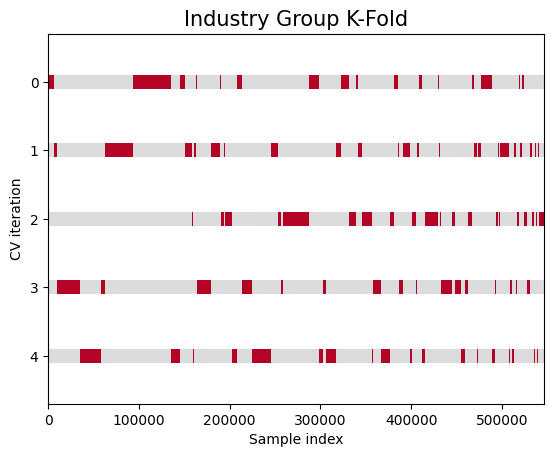

In [ ]:
# GroupKfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train.sort_values(by='LEncodedIndustry'),
                y=Y_train,
                cv=kf,
                group=groups,
                ax=ax,
                split_strategy='Industry Group K-Fold')

In [ ]:
# 학습 데이터를 GroupKfold로 나눕니다.
train_folds = kf.split(X_train, Y_train, groups=groups)
display(train_folds)

<generator object _BaseKFold.split at 0x7e42278bf5a0>


In [ ]:
# 학습을 진행합니다.
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"industry_groupd_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8084
[LightGBM] [Info] Number of data points in the train set: 437099, number of used features: 42
[LightGBM] [Info] Start training from score 44935.493529
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 37945.7	training's l2: 1.43987e+09	valid_1's rmse: 15999.8	valid_1's l2: 2.55993e+08
[20]	training's rmse: 13846.1	training's l2: 1.91713e+08	valid_1's rmse: 5771.39	valid_1's l2: 3.3309e+07
[30]	training's rmse: 6036.88	training's l2: 3.6444e+07	valid_1's rmse: 2435.01	valid_1's l2: 5.92927e+06
[40]	training's rmse: 4010.15	training's l2: 1.60813e+07	valid_1's rmse: 1603.71	valid_1's l2: 2.57189e+06
[50]	training's rmse: 3538.95	training's l2: 1.25242e+07	valid

In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

industry_groupd_kfold0_gbm.pkl - Test rmse : 3347.861375999408
industry_groupd_kfold1_gbm.pkl - Test rmse : 3476.9035713858702
industry_groupd_kfold2_gbm.pkl - Test rmse : 4177.14298261633
industry_groupd_kfold3_gbm.pkl - Test rmse : 4047.035842525753
industry_groupd_kfold4_gbm.pkl - Test rmse : 6440.900450650537
최종 Test rmse : 3529.9999292085126


In [ ]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["industry_groupd_kfold0_gbm.pkl", "industry_groupd_kfold1_gbm.pkl", "industry_groupd_kfold2_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

industry_groupd_kfold0_gbm.pkl - Test rmse : 3347.861375999408
industry_groupd_kfold1_gbm.pkl - Test rmse : 3476.9035713858702
industry_groupd_kfold2_gbm.pkl - Test rmse : 4177.14298261633
최종 Test rmse : 3288.7691232041448


In [ ]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[91077 91078 91079 91080 91081]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[182152 182153 182154 182155 182156]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[273227 273228 273229 273230 273231]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[364302 364303 364304 364305 364306]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[455377 455378 455379 455380 455381]...


<Axes: title={'center': 'Time-Series K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

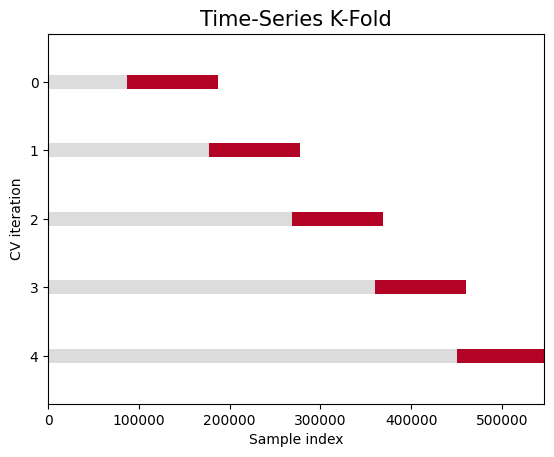

In [ ]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [ ]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object TimeSeriesSplit.split at 0x7e422a48c9e0>


In [ ]:
# 학습을 진행합니다.
%%time
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7615
[LightGBM] [Info] Number of data points in the train set: 91077, number of used features: 42
[LightGBM] [Info] Start training from score 58520.669774
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 44145.3	training's l2: 1.94881e+09	valid_1's rmse: 19346.7	valid_1's l2: 3.74295e+08
[20]	training's rmse: 15845.4	training's l2: 2.51076e+08	valid_1's rmse: 6923.21	valid_1's l2: 4.79309e+07
[30]	training's rmse: 6516.85	training's l2: 4.24694e+07	valid_1's rmse: 2868.05	valid_1's l2: 8.22571e+06
[40]	training's rmse: 3986.11	training's l2: 1.58891e+07	valid_1's rmse: 1841.37	valid_1's l2: 3.39065e+06
[50]	training's rmse: 3431.41	training's l2: 1.17746e+07	vali

In [ ]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

timeseries_fold0_gbm.pkl - Test rmse : 3385.4259422007062
timeseries_fold1_gbm.pkl - Test rmse : 4690.945209050336
timeseries_fold2_gbm.pkl - Test rmse : 3768.5173170757444
timeseries_fold3_gbm.pkl - Test rmse : 3529.792141618723
timeseries_fold4_gbm.pkl - Test rmse : 3449.11416041251
최종 Test rmse : 3295.3232363359216


In [ ]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold0_gbm.pkl", "timeseries_fold2_gbm.pkl", "timeseries_fold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

timeseries_fold0_gbm.pkl - Test rmse : 3385.4259422007062
timeseries_fold2_gbm.pkl - Test rmse : 3768.5173170757444
timeseries_fold4_gbm.pkl - Test rmse : 3449.11416041251
최종 Test rmse : 3211.7475472329493
